# Capstone Project - Which city has the Best Night Clubs? Las Vegas? Miami? New York City? (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem

Millions of people love to travel and explore new places across the world all the time.  

Before they plan their trip ahead. Most of the tourists will try to get find the best place to dine, party, visit, etc.  

We all know **Las Vegas**, **New York City**, and **Miami** are the most popular tourist destinations among others in the USA.Each place is unique and known for its own attraction.

**The entertainment capital of the world** LAS VEGAS is known for its gambling, shopping, fine dining, entertainment, and nightlife.The major attraction in Las Vegas are the casinos and the hotels and each casino have their own nightclubs. 

**The city that never sleeps** NEW YORK is known for many Broadway theaters, cinemas, and electronic billboards and nightlife. It got some of the world's most famous bars, music clubs, and night clubs. 

**Miami** South Beach is home to some of the most beautiful beaches and outstanding nightclubs in the country. 
The city attracts the second-highest number of foreign tourists of any city in the United States, after New York City.

If the tourist is a party lover. He/She likes to know among **Miami, Vegas, and New York**. Which city has the best **Night clubs** besides other places of interest?
Lets find out......!

## Data

In order to address the above problem. We have to know:
* The best Night clubs in each city. 
* Their Ratings 
* Price
* Likes
* Tips

We will be looking at those Night Clubs which are with in 25 miles radius of the City.

Following data sources will be needed to extract/generate the required information:
* cities Lat and Long values will be obtained using Google Maps API reverse geocoding
* venue details in our case Night Clubs details and location will be obtained using Foursquare API

**Note:** We will be exploring only the *Top 25 Night Clubs* for each city.

## Importing all required libraries

In [8]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd
import json # library to handle JSON files
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
import folium # map rendering library

print('All Libraries imported.')

All Libraries imported.


### Pass FourSquare API

In [1]:
CLIENT_ID = '2UD1WZDJ1TQISPF0UQIJVSHLG4HE1TQ005KWJMJ30UC1LNZV'
CLIENT_SECRET = 'FJ0XVQIAYWZ5FDEB11F3HSGWMRA1JP0UE2UREG5JTV0HYK00'
VERSION = '20200427' # Foursquare API version

### Searching for Nightclubs with in 25 miles radius of the city.

In [9]:
limit = 1000
radius= 50000 # in meters
search_query=['club']

In [10]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

### Function takes the city parameter and produces city's Nightclubs data

In [11]:
def get_venue_data(city):
    address = city
    geolocator = Nominatim(user_agent="explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        latitude, 
        longitude, 
        VERSION, 
        search_query,
        radius, 
        limit)
    
    results = requests.get(url).json()
    
    venues = results['response']['groups'][0]['items']

    
    df_name = pd.json_normalize(venues) # flatten JSON

    # filter columns
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng','venue.id']
    df_name =df_name.loc[:, filtered_columns]

    # filter the category for each row
    df_name['venue.categories'] = df_name.apply(get_category_type, axis=1)

    # clean columns
    df_name.columns = [col.split(".")[-1] for col in df_name.columns]

    return df_name



### Calling the function for each city.

In [12]:
newyork = get_venue_data('New York,NY')

In [13]:
vegas = get_venue_data('Las Vegas,NV')

In [14]:
miami = get_venue_data('Miami,FL')

### Sticking to just Night Clubs data

In [15]:
club_miami = miami[miami['categories'].str.lower().str.contains('club')]

In [16]:
club_vegas = vegas[vegas['categories'].str.lower().str.contains('club')]

In [17]:
club_ny = newyork[newyork['categories'].str.lower().str.contains('club')]

This finishes our first part of the data. For now we have the basic information regarding the Night clubs for each city.  
Now we have to work on getting the futher details of each venue (Night Club) includes rating, likes, counts and price.

### Function to add venue details like rating, price,likes,tips to the original dataframe

In [19]:
def add_newcolumns(df_name):
    cols = df_name.columns.values.tolist() + ['rating','price','likes','tips']
    
    new_df = pd.DataFrame(columns=cols)
    new_df['name'] = df_name['name']
    

    for r in np.arange(df_name.shape[0]):
        venue_id = df_name.iloc[r,-1]
        url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
        result = requests.get(url).json()
        details = result['response']['venue']
        df = pd.json_normalize(details)
        # checking if rating exists
        if 'rating' in df.columns:
            rating = df['rating'].values[0]
        else:
            rating = 0 
        # checking if price exits    
        if 'price.message' in df.columns:
            price = df['price.message'].values[0]
        else:
            price = 'NaN'
        # checking if likes exits 
        if 'likes.count' in df.columns:
            likes = df['likes.count'].values[0]
        else:
            likes = 0
            
        # checking if tips exits 
        if 'tips.count' in df.columns:
            tips = df['tips.count'].values[0]
        else:
            tips = 0
        
            
        #new_data = df[['rating','price.message','likes.count','tips.count']].values.tolist()[0]
        new_data = [rating,price,likes,tips]
        new_df.iloc[r,1:] = np.array(df_name.iloc[r,1:].values.tolist()+new_data).reshape(1,8)
        
    return new_df
    

 


In [20]:
club_miami_new = add_newcolumns(club_miami)

In [21]:
club_ny_new = add_newcolumns(club_ny)

In [22]:
club_vegas_new = add_newcolumns(club_vegas)

### Funtion to change datatypes to float and int

In [30]:
# Columns to change data types to int
#C = ['rating', 'likes', 'tips']
def change_datatype(df_name,col_list):
    for col in col_list:
        if col in ['rating','lat','lng']:
            df_name.loc[:,col] = df_name[col].astype(float)
        else:
            df_name.loc[:,col] = df_name[col].astype(int)
    return df_name

In [31]:
club_vegas_new = change_datatype(club_vegas_new,['rating', 'likes', 'tips','lat','lng'])
club_ny_new = change_datatype(club_ny_new,['rating', 'likes', 'tips','lat','lng'])
club_miami_new = change_datatype(club_miami_new,['rating', 'likes', 'tips','lat','lng'])

### Lets explore only the Top 25 Night Clubs from each city.

In [32]:
top_25_ny = club_ny_new[(club_ny_new.rating>6.5)&(club_ny_new.categories=='Nightclub')].sort_values('rating',ascending=False).head(25)

In [33]:
top_25_miami = club_miami_new[(club_miami_new.rating>6.5)&(club_miami_new.categories=='Nightclub')].sort_values('rating',ascending=False).head(25)

In [34]:
top_25_vegas = club_vegas_new[(club_vegas_new.rating>6.5)&(club_vegas_new.categories=='Nightclub')].sort_values('rating',ascending=False).head(25)

### Lets get the geographical data for each city to plot the graph

In [59]:
geo_miami = top_25_miami[['name','lat','lng','rating','price']]
geo_vegas = top_25_vegas[['name','lat','lng','rating','price']]
geo_ny = top_25_ny[['name','lat','lng','rating','price']]


In [41]:
def get_geo_city(add,df_name):
    address = add

    geolocator = Nominatim(user_agent="to_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    #print('The geograpical coordinate of Miami are {}, {}.'.format(latitude, longitude))
    m = folium.Map(location=[latitude, longitude], zoom_start=11)

    # add markers to the map
    for lat, lon, rating,club in zip(df_name['lat'], df_name['lng'], df_name['rating'], df_name['name']):
        label = folium.Popup(club + ' Rating - ' + str(rating), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(m)

    return m

### Miami Map with Top 25 Night Clubs

In [43]:
miami_map = get_geo_city('Miami,Florida',geo_miami)
miami_map

### Vegas Map with Top 25 Night Clubs

In [44]:
vegas_map = get_geo_city('Las Vegas,Nevada',geo_vegas)
vegas_map

### New York City map with Top 25 Night Clubs

In [150]:
ny_map = get_geo_city('New York City, New York',geo_ny)
ny_map

## Methodology

In this project, we will limit our efforts to the Night clubs which are located within 25 miles radius from the city center. Also, we only deal with **Top 25 Night Clubs**.

In the first step, we have collected the required **data: Club name, Lat, Long, id of each night club within 25 miles radius** using FourSquare API.

In the second step we went further to get more details about each Night Club like **rating, price, likes, tips** and visually displayed the Night Clubs for each city on their maps. 

In the next step we will **Hot Encode** any categorical data in our case **price** column. Once we hot encode the price column, we move forward in normalizing the data. Since each column data varies within a different range of numbers. After we normalize the data, we will get the **mean values** first at row level and then **mean score value** of those mean values for each city.


### Hot Encoding the price column to get the numeric values.

In [48]:
ny_hot = pd.get_dummies(top_25_ny.set_index('name')[['rating','likes','tips','price']])
miami_hot = pd.get_dummies(top_25_miami.set_index('name')[['rating','likes','tips','price']])
vegas_hot = pd.get_dummies(top_25_vegas.set_index('name')[['rating','likes','tips','price']])

### Function to normalize the numeric values applies to rating, likes, tips columns

In [50]:
def normalize_data(df_name,col_list):
    for col in col_list:
        df_name.loc[:,col] = df_name[col]/df_name[col].max()
    return df_name

ny_hot = normalize_data(ny_hot,['rating', 'likes', 'tips'])
miami_hot = normalize_data(miami_hot,['rating', 'likes', 'tips'])
vegas_hot = normalize_data(vegas_hot,['rating', 'likes', 'tips'])

In [51]:
r1 = ny_hot.mean(1).mean(),miami_hot.mean(1).mean(),vegas_hot.mean(1).mean()
df1 = pd.DataFrame(r1,index=['NY','Miami','Vegas'],columns = ['Clubs mean score'])
df1

,Clubs mean score
NY,0.320808
Miami,0.394363
Vegas,0.332649


## Analysis

Lets peform some analysis and try to extract some information based on charts

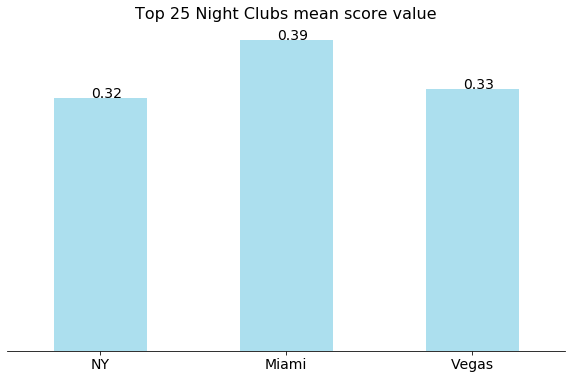

In [52]:
%matplotlib inline
import matplotlib.pyplot as plt
xlabels = df1.index.values.tolist()
ax = df1.plot(kind='bar',figsize=(10,6),alpha=0.5,color='#5bc0de')

for p in ax.patches:
    value = '{:.2f}'.format(p.get_height())
    width,height = p.get_width(),p.get_height()
    x=p.get_x()+width-0.3
    y=p.get_y()+height+0.001
    ax.annotate(value,(x,y),fontsize=14)
    


ax.get_yaxis().set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_title('Top 25 Night Clubs mean score value',fontsize=16)
ax.get_legend().remove()
ax.set_xticklabels(xlabels,fontsize=14,rotation=0);


As we can see **Miami** got the best clubs as per above data followed by **Vegas** and **New York city**.  
**Note:** Here we are including clubs rating, likes, price and tips (Data from FourSquare API)

### Lets explore further by looking at all factors i,e rating, likes, tips & price.

In [53]:
df2 = pd.DataFrame(ny_hot.mean(),columns=['NY']).T.rename(columns={'price_Cheap':'Cheap','price_Expensive':'Expensive','price_Moderate':'Moderate','price_Very Expensive':'Very Expensive','rating':'Rating','likes':'Likes','tips':'Tips'})
df3 = pd.DataFrame(miami_hot.mean(),columns=['Miami']).T.rename(columns={'price_Cheap':'Cheap','price_Expensive':'Expensive','price_Moderate':'Moderate','price_Very Expensive':'Very Expensive','rating':'Rating','likes':'Likes','tips':'Tips'})
df4 = pd.DataFrame(vegas_hot.mean(),columns=['Vegas']).T.rename(columns={'price_Cheap':'Cheap','price_Expensive':'Expensive','price_Moderate':'Moderate','price_Very Expensive':'Very Expensive','rating':'Rating','likes':'Likes','tips':'Tips'})
frames =[df2,df3,df4]
df5 = pd.concat(frames)

In [154]:
df5

,Rating,Likes,Tips,Cheap,Expensive,Moderate,Very Expensive
NY,0.900220,0.183376,0.162063,0.08,0.52,0.28,0.12
Miami,0.938636,0.256437,0.171107,NaN,0.48,0.36,0.16
Vegas,0.844211,0.237987,0.246347,0.04,0.64,0.08,0.24


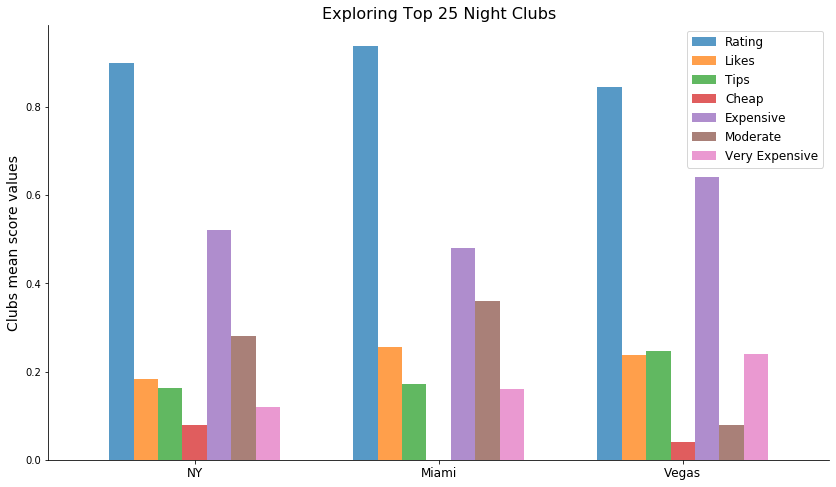

In [55]:
ax = df5.plot(kind='bar',figsize=(14,8),alpha=0.75,width=0.7)
ax.set_ylabel('Clubs mean score values',fontsize=14)
ax.set_xticklabels(xlabels,fontsize=12,rotation=0)
ax.set_title('Exploring Top 25 Night Clubs',fontsize=16)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(fontsize=12);


Based on the above chart.   
**Expensive and Very Expensive Clubs:** Vegas, NY, Miami  
**Rating:** Miami, NY, Vegas  
**Likes:** Vegas and Miami got almost similar likes followed by NY  
**Tips:** Vegas, Miami, NY 

### Lets get the counts of Night Clubs falling into different rating bins

In [157]:
miami = top_25_miami['rating'].reset_index(drop=True)
h_miami = pd.DataFrame(miami).rename(columns={'rating':'miami'}).T

vegas = top_25_vegas['rating'].reset_index(drop=True)
h_vegas = pd.DataFrame(vegas).rename(columns={'rating':'vegas'}).T

ny = top_25_ny['rating'].reset_index(drop=True)
h_ny = pd.DataFrame(ny).rename(columns={'rating':'ny'}).T

h_f = [h_miami,h_vegas,h_ny]
h_df = pd.concat(h_f).T
print('Top 25 Night Clubs from each city with Ratings')
h_df

Top 25 Night Clubs from each city with Ratings


,miami,vegas,ny
0,8.8,9.5,9.1
1,8.8,9.0,8.8
2,8.7,8.8,8.8
3,8.7,8.6,8.6
4,8.6,8.5,8.6
5,8.6,8.5,8.5
6,8.5,8.5,8.5
7,8.4,8.4,8.3
8,8.4,8.0,8.3
9,8.3,7.9,8.2


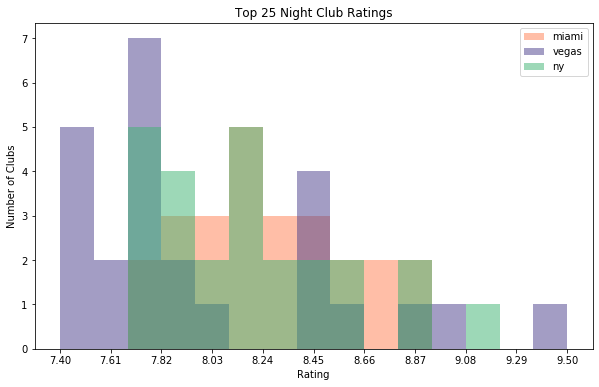

In [146]:
count, bin_edges = np.histogram(h_df)

h_df.plot(kind ='hist', 
          figsize=(10, 6),
          bins=15,
          alpha=0.5,
          xticks=bin_edges,
          color=['coral', 'darkslateblue', 'mediumseagreen']
         )

plt.title('Top 25 Night Club Ratings')
plt.ylabel('Number of Clubs')
plt.xlabel('Rating')

plt.show()

## Lets look at those Top 25 Night Clubs from Miami

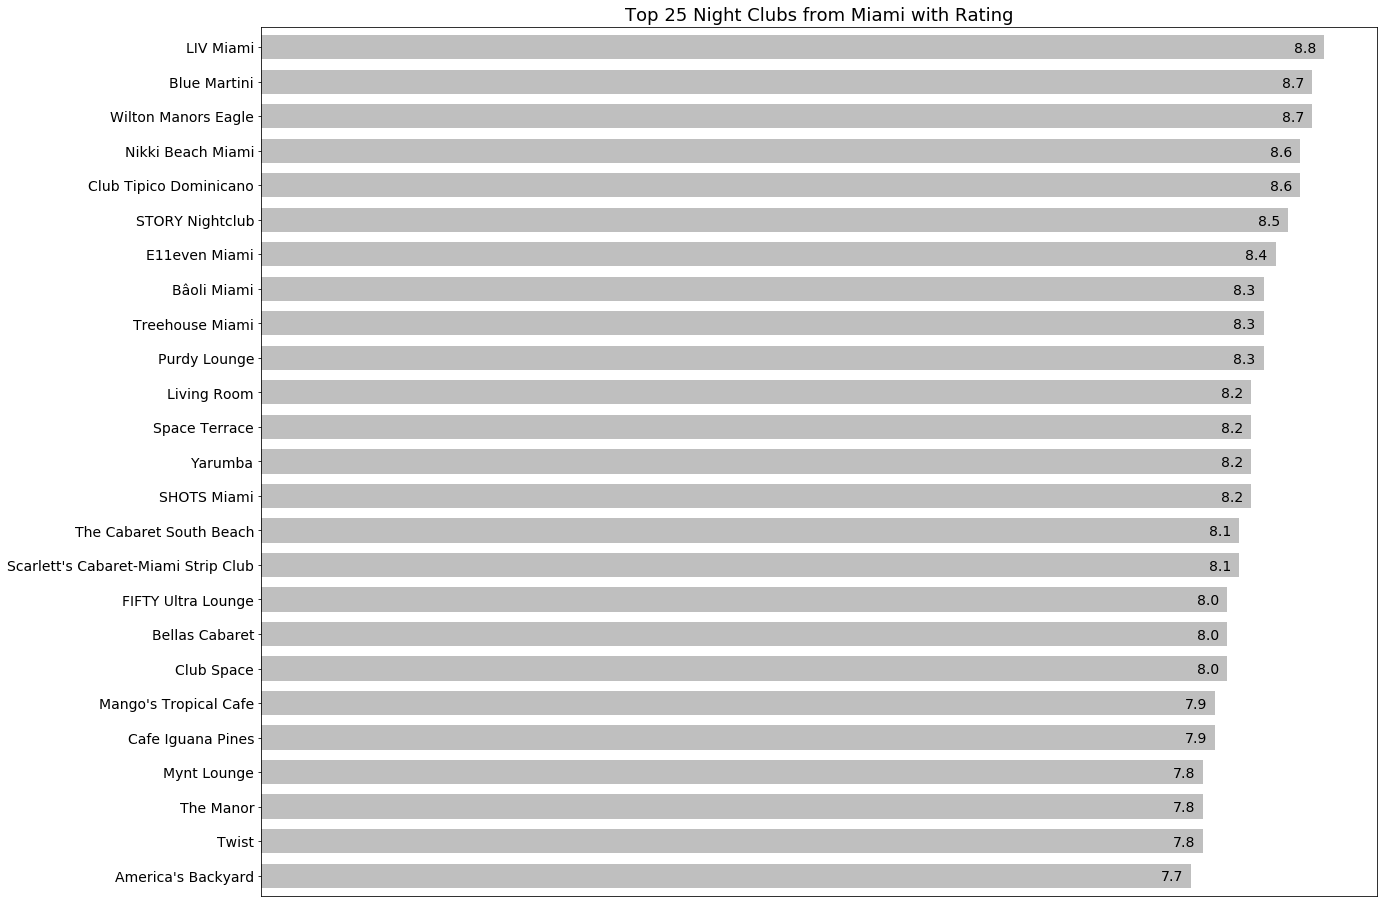

In [271]:

df6 = top_25_miami.sort_values('rating').set_index('name')['rating']
y_labels = df6.index.values.tolist()
ax = df6.plot(kind='barh',figsize=(20,16),width=0.7,alpha=0.5,color='grey')

for p in ax.patches:
    value = '{:.1f}'.format(p.get_width())
    width,height = p.get_width(),p.get_height()
    x=p.get_x()+width-0.25
    y=p.get_y()+height-0.5
    ax.annotate(value,(x,y),fontsize=14)

ax.set_xlabel('Rating',fontsize=14)
ax.set_title('Top 25 Night Clubs from Miami with Rating', fontsize=18)
ax.set_ylabel('')
ax.get_xaxis().set_visible(False)
#ax.get_yaxis().set_visible(False)
ax.set_yticklabels(y_labels,fontsize=14);




In [57]:
def replace_price(price):
    if price=='Very Expensive':
        return 3
    elif price=='Expensive':
        return 2
    else:
        return 1


In [60]:
new_geo_miami = geo_miami
new_geo_miami.loc[:,'price'] = new_geo_miami.loc[:,'price'].apply(lambda x:replace_price(x))
price_range = new_geo_miami['price'].max()


C:\Users\thamats\Anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


### Top 25 Night Clubs in Miami clustered with price category

In [64]:
# Getting Totonto lat and long values.
address = 'Miami,Florida'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
#print('The geograpical coordinate of Miami are {}, {}.'.format(latitude, longitude))
map_miami = folium.Map(location=[latitude, longitude], zoom_start=12)

x = np.arange(1,price_range+1)
ys = [i + x + (i*x)**2 for i in range(price_range)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, rating,club,price in zip(geo_miami['lat'], geo_miami['lng'], geo_miami['rating'], geo_miami['name'],geo_miami['price']):
    label = folium.Popup(club + ' Rating - ' + str(rating), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        #color='blue',
        color=rainbow[price-1],
        fill=True,
        #fill_color='#3186cc',
        fill_color=rainbow[price-1],
        fill_opacity=0.7,
        parse_html=False).add_to(map_miami)
    
map_miami

## Results & Discussion

Our Analysis shows that although **Las Vegas** Night clubs got the best ratings. **Miami** Night clubs has more number of average ratings.  
**Las Vegas** still leads in terms of likes and tips when compared to other cities Night clubs. 
We also identified Vegas Night clubs have more **Expensive and very Expensive** Night clubs followed by Miami and NY Night clubs.  
May be **Las Vegas** Night Clubs has to bring down their prices to get better ratings.

## Conclusion

Purpose of this project to find the wihch city has the best Night clubs.It would help a tourist who loves night life and parties. 
After exploring the above data. It's Noticeable that **Miami** has the best Night Clubs when compared to **Las Vegas** and **NY**.  
